In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
df = pd.read_csv('/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2GPT/multiple_light_seqs_from_single_heavy/full_test_set_multiple_light_seqs/full_eval_generate_multiple_light_seqs_203276_cls_predictions.csv')

print("Dataset Overview:")
print(f"Total rows: {len(df)}")
print(f"Unique heavy chains: {df['heavy_chain_number'].nunique()}")
print(f"Generated light chains per heavy chain: {df['gen_light_chain_number'].max()}")
print("\nFirst few rows:")
print(df.head())

Dataset Overview:
Total rows: 588289
Unique heavy chains: 58838
Generated light chains per heavy chain: 10

First few rows:
   heavy_chain_number  gen_light_chain_number  \
0                   1                       1   
1                   1                       2   
2                   1                       3   
3                   1                       4   
4                   1                       5   

                                      true_light_seq  \
0  DIQMTQSPSTLSASVGDRVTITCRASHSINTWLAWYQQKPGKAPKL...   
1  DIQMTQSPSTLSASVGDRVTITCRASHSINTWLAWYQQKPGKAPKL...   
2  DIQMTQSPSTLSASVGDRVTITCRASHSINTWLAWYQQKPGKAPKL...   
3  DIQMTQSPSTLSASVGDRVTITCRASHSINTWLAWYQQKPGKAPKL...   
4  DIQMTQSPSTLSASVGDRVTITCRASHSINTWLAWYQQKPGKAPKL...   

                                       gen_light_seq  \
0  QSALTQPPSASGSPGQSVTISCTGTSSDIGGYNFVSWYQQHPGKAP...   
1  SSELTQDPAVSVALGQTVRITCQGDSLRSYYASWYQQKPGQAPLLV...   
2  DIVMTQSPDSLAVSLGERATINCKSSQSVLYSPNNKNYLGWYQQKP...   
3  EIVLTQSPATLSLSPGE

In [3]:
# 1. Basic label distribution analysis
print("\n" + "="*50)
print("LABEL DISTRIBUTION ANALYSIS")
print("="*50)

print("\nHeavy chain label distribution:")
heavy_labels = df.groupby('heavy_chain_number')['predicted_input_heavy_seq_label'].first()
print(heavy_labels.value_counts())
print(f"Naive (0): {(heavy_labels == 0).sum()}")
print(f"Memory (1): {(heavy_labels == 1).sum()}")

print("\nGenerated light chain label distribution:")
gen_light_labels = df['predicted_gen_light_seq_label'].value_counts()
print(gen_light_labels)

print("\nTrue light chain label distribution:")
true_light_labels = df['predicted_true_light_seq_label'].value_counts()
print(true_light_labels)


LABEL DISTRIBUTION ANALYSIS

Heavy chain label distribution:
predicted_input_heavy_seq_label
1    44961
0    13877
Name: count, dtype: int64
Naive (0): 13877
Memory (1): 44961

Generated light chain label distribution:
predicted_gen_light_seq_label
0    358453
1    229836
Name: count, dtype: int64

True light chain label distribution:
predicted_true_light_seq_label
1    401513
0    186776
Name: count, dtype: int64


In [6]:
# 2. Matching analysis: Generated light chains vs Heavy chains
print("\n" + "="*50)
print("MATCHING ANALYSIS: Generated Light Chains vs Heavy Chains")
print("="*50)

# Calculate matches for each heavy chain
matching_results = []
for heavy_chain in df['heavy_chain_number'].unique():
    heavy_data = df[df['heavy_chain_number'] == heavy_chain]
    heavy_label = heavy_data['predicted_input_heavy_seq_label'].iloc[0]
    
    matches = (heavy_data['predicted_gen_light_seq_label'] == heavy_label).sum()
    total_generated = len(heavy_data)
    match_percentage = (matches / total_generated) * 100
    
    matching_results.append({
        'heavy_chain': heavy_chain,
        'heavy_label': heavy_label,
        'matches': matches,
        'total_generated': total_generated,
        'match_percentage': match_percentage
    })

matching_df = pd.DataFrame(matching_results)

print(f"\nOverall matching statistics:")
print(f"Average matching percentage: {matching_df['match_percentage'].mean():.2f}%")
print(f"Median matching percentage: {matching_df['match_percentage'].median():.2f}%")
print(f"Standard deviation: {matching_df['match_percentage'].std():.2f}%")



MATCHING ANALYSIS: Generated Light Chains vs Heavy Chains

Overall matching statistics:
Average matching percentage: 58.02%
Median matching percentage: 60.00%
Standard deviation: 35.47%


In [9]:
# show entries where heavy_label is 0 
matching_df[matching_df['heavy_label'] == 0]


,heavy_chain,heavy_label,matches,total_generated,match_percentage
30,31,0,10,10,100.0
65,66,0,9,10,90.0
70,71,0,9,10,90.0
139,140,0,10,10,100.0
184,185,0,10,10,100.0
...,...,...,...,...,...
57995,57996,0,8,10,80.0
58103,58105,0,9,10,90.0
58169,58171,0,8,10,80.0
58259,58261,0,9,10,90.0


In [7]:

# Separate analysis by heavy chain label
naive_heavy = matching_df[matching_df['heavy_label'] == 0]
memory_heavy = matching_df[matching_df['heavy_label'] == 1]

print(f"\nFor NAIVE heavy chains (label 0):")
print(f"  Average matching: {naive_heavy['match_percentage'].mean():.2f}%")
print(f"  Median matching: {naive_heavy['match_percentage'].median():.2f}%")

print(f"\nFor MEMORY heavy chains (label 1):")
print(f"  Average matching: {memory_heavy['match_percentage'].mean():.2f}%")
print(f"  Median matching: {memory_heavy['match_percentage'].median():.2f}%")



For NAIVE heavy chains (label 0):
  Average matching: 90.16%
  Median matching: 90.00%

For MEMORY heavy chains (label 1):
  Average matching: 48.10%
  Median matching: 40.00%


In [10]:
# 3. Pattern analysis: Label switching during generation
print("\n" + "="*50)
print("LABEL SWITCHING PATTERN ANALYSIS")
print("="*50)

switching_patterns = []
for heavy_chain in df['heavy_chain_number'].unique():
    heavy_data = df[df['heavy_chain_number'] == heavy_chain].sort_values('gen_light_chain_number')
    heavy_label = heavy_data['predicted_input_heavy_seq_label'].iloc[0]
    
    # Get the sequence of generated labels
    gen_labels = heavy_data['predicted_gen_light_seq_label'].tolist()
    
    # Count switches
    switches = 0
    for i in range(1, len(gen_labels)):
        if gen_labels[i] != gen_labels[i-1]:
            switches += 1
    
    # Find switching points
    switch_points = []
    for i in range(1, len(gen_labels)):
        if gen_labels[i] != gen_labels[i-1]:
            switch_points.append(i)
    
    switching_patterns.append({
        'heavy_chain': heavy_chain,
        'heavy_label': heavy_label,
        'gen_labels': gen_labels,
        'num_switches': switches,
        'switch_points': switch_points,
        'starts_matching': gen_labels[0] == heavy_label,
        'ends_matching': gen_labels[-1] == heavy_label
    })

switching_df = pd.DataFrame(switching_patterns)

print(f"\nSwitching statistics:")
print(f"Average number of switches per heavy chain: {switching_df['num_switches'].mean():.2f}")
print(f"Heavy chains with no switches: {(switching_df['num_switches'] == 0).sum()}")
print(f"Heavy chains with 1+ switches: {(switching_df['num_switches'] > 0).sum()}")

# Common switching patterns
print(f"\nPattern analysis:")
starts_matching = switching_df['starts_matching'].sum()
ends_matching = switching_df['ends_matching'].sum()
print(f"Heavy chains where first generated light chain matches heavy: {starts_matching}")
print(f"Heavy chains where last generated light chain matches heavy: {ends_matching}")



LABEL SWITCHING PATTERN ANALYSIS

Switching statistics:
Average number of switches per heavy chain: 2.36
Heavy chains with no switches: 17861
Heavy chains with 1+ switches: 40977

Pattern analysis:
Heavy chains where first generated light chain matches heavy: 34132
Heavy chains where last generated light chain matches heavy: 34006


In [11]:
# 4. Detailed switching analysis by heavy chain type
print(f"\nSwitching by heavy chain type:")
for label, label_name in [(0, 'NAIVE'), (1, 'MEMORY')]:
    subset = switching_df[switching_df['heavy_label'] == label]
    print(f"\n{label_name} heavy chains:")
    print(f"  Average switches: {subset['num_switches'].mean():.2f}")
    print(f"  Chains with no switches: {(subset['num_switches'] == 0).sum()}")
    print(f"  First gen matches heavy: {subset['starts_matching'].sum()}")
    print(f"  Last gen matches heavy: {subset['ends_matching'].sum()}")

# 5. Generation order analysis
print("\n" + "="*50)
print("GENERATION ORDER ANALYSIS")
print("="*50)

# Analyze how labels change across generation order
order_analysis = df.groupby('gen_light_chain_number')['predicted_gen_light_seq_label'].agg(['mean', 'count'])
print("\nAverage label by generation order:")
print(order_analysis)


Switching by heavy chain type:

NAIVE heavy chains:
  Average switches: 1.54
  Chains with no switches: 5746
  First gen matches heavy: 12547
  Last gen matches heavy: 12471

MEMORY heavy chains:
  Average switches: 2.61
  Chains with no switches: 12115
  First gen matches heavy: 21585
  Last gen matches heavy: 21535

GENERATION ORDER ANALYSIS

Average label by generation order:
                            mean  count
gen_light_chain_number                 
1                       0.389438  58831
2                       0.392313  58828
3                       0.391984  58829
4                       0.391534  58825
5                       0.390705  58827
6                       0.390668  58830
7                       0.389835  58830
8                       0.389234  58831
9                       0.391229  58830
10                      0.389916  58828



CREATING VISUALIZATIONS


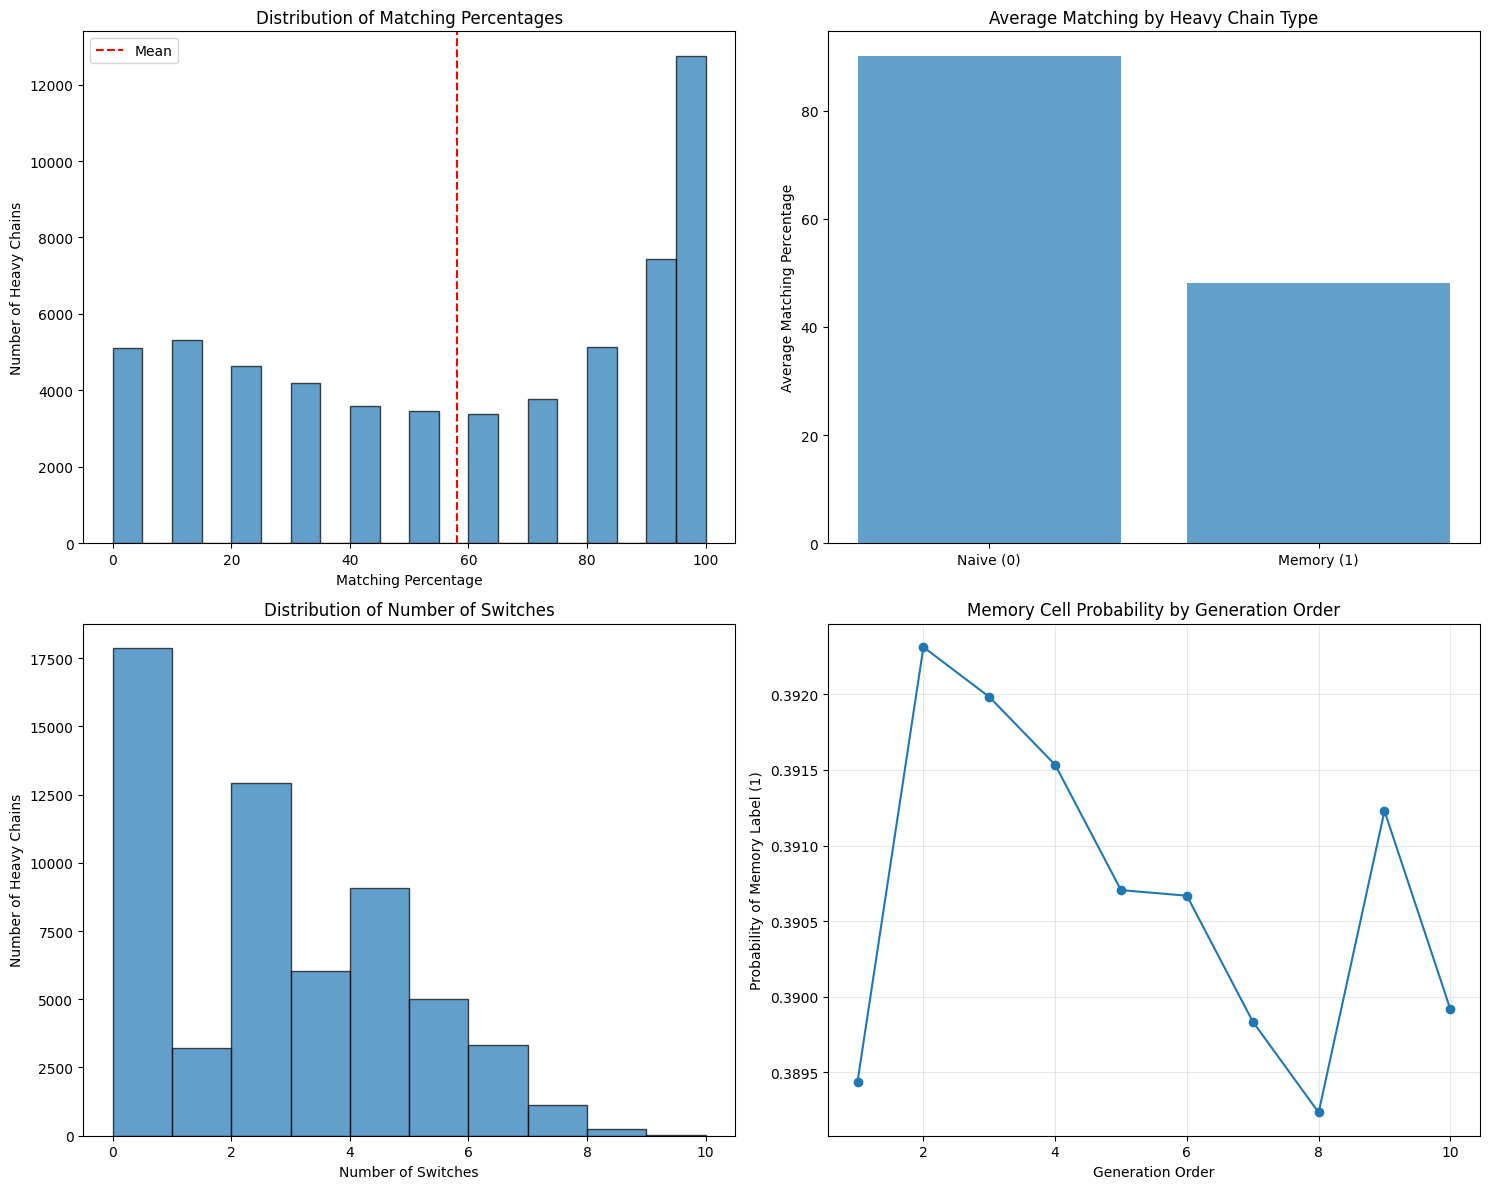


EXAMPLE SWITCHING PATTERNS

Examples of heavy chains with multiple switches:

Heavy chain 1 (label 1):
  Generated labels: [1, 0, 1, 1, 0, 0, 1, 1, 1, 1]
  Number of switches: 4
  Switch points: [1, 2, 4, 6]

Heavy chain 2 (label 1):
  Generated labels: [1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
  Number of switches: 2
  Switch points: [4, 5]

Heavy chain 3 (label 1):
  Generated labels: [1, 1, 0, 1, 1, 1, 1, 1, 0, 0]
  Number of switches: 3
  Switch points: [2, 3, 8]


In [13]:
# 6. Visualization setup
print("\n" + "="*50)
print("CREATING VISUALIZATIONS")
print("="*50)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Matching percentage distribution
axes[0, 0].hist(matching_df['match_percentage'], bins=20, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Matching Percentages')
axes[0, 0].set_xlabel('Matching Percentage')
axes[0, 0].set_ylabel('Number of Heavy Chains')
axes[0, 0].axvline(matching_df['match_percentage'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Plot 2: Matching by heavy chain type
match_by_type = matching_df.groupby('heavy_label')['match_percentage'].mean()
axes[0, 1].bar(['Naive (0)', 'Memory (1)'], match_by_type.values, alpha=0.7)
axes[0, 1].set_title('Average Matching by Heavy Chain Type')
axes[0, 1].set_ylabel('Average Matching Percentage')

# Plot 3: Number of switches distribution
axes[1, 0].hist(switching_df['num_switches'], bins=range(0, switching_df['num_switches'].max()+2), 
                alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution of Number of Switches')
axes[1, 0].set_xlabel('Number of Switches')
axes[1, 0].set_ylabel('Number of Heavy Chains')

# Plot 4: Label probability by generation order
order_probs = df.groupby('gen_light_chain_number')['predicted_gen_light_seq_label'].mean()
axes[1, 1].plot(order_probs.index, order_probs.values, 'o-')
axes[1, 1].set_title('Memory Cell Probability by Generation Order')
axes[1, 1].set_xlabel('Generation Order')
axes[1, 1].set_ylabel('Probability of Memory Label (1)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Detailed examples of switching patterns
print("\n" + "="*50)
print("EXAMPLE SWITCHING PATTERNS")
print("="*50)
# Show a few examples of interesting switching patterns
print("\nExamples of heavy chains with multiple switches:")
multi_switch = switching_df[switching_df['num_switches'] >= 2].head(3)
for idx, row in multi_switch.iterrows():
    print(f"\nHeavy chain {row['heavy_chain']} (label {row['heavy_label']}):")
    print(f"  Generated labels: {row['gen_labels']}")
    print(f"  Number of switches: {row['num_switches']}")
    print(f"  Switch points: {row['switch_points']}")


In [15]:


# 8. Summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

total_generated = len(df)
total_matches = (df['predicted_gen_light_seq_label'] == df['predicted_input_heavy_seq_label']).sum()
overall_match_rate = (total_matches / total_generated) * 100

print(f"\nOverall Summary:")
print(f"Total generated light chains: {total_generated}")
print(f"Total matches with heavy chain: {total_matches}")
print(f"Overall matching rate: {overall_match_rate:.2f}%")

# True light chain comparison
true_matches = (df['predicted_true_light_seq_label'] == df['predicted_input_heavy_seq_label']).sum()
true_match_rate = (true_matches / len(df)) * 100
print(f"\nTrue light chain matching rate with heavy: {true_match_rate:.2f}%")

print(f"\nGeneration Quality Assessment:")
print(f"Generated light chains perform {'better' if overall_match_rate > true_match_rate else 'worse'} than true light chains")
print(f"Difference: {abs(overall_match_rate - true_match_rate):.2f} percentage points")




SUMMARY STATISTICS

Overall Summary:
Total generated light chains: 588289
Total matches with heavy chain: 341304
Overall matching rate: 58.02%

True light chain matching rate with heavy: 90.32%

Generation Quality Assessment:
Generated light chains perform worse than true light chains
Difference: 32.30 percentage points


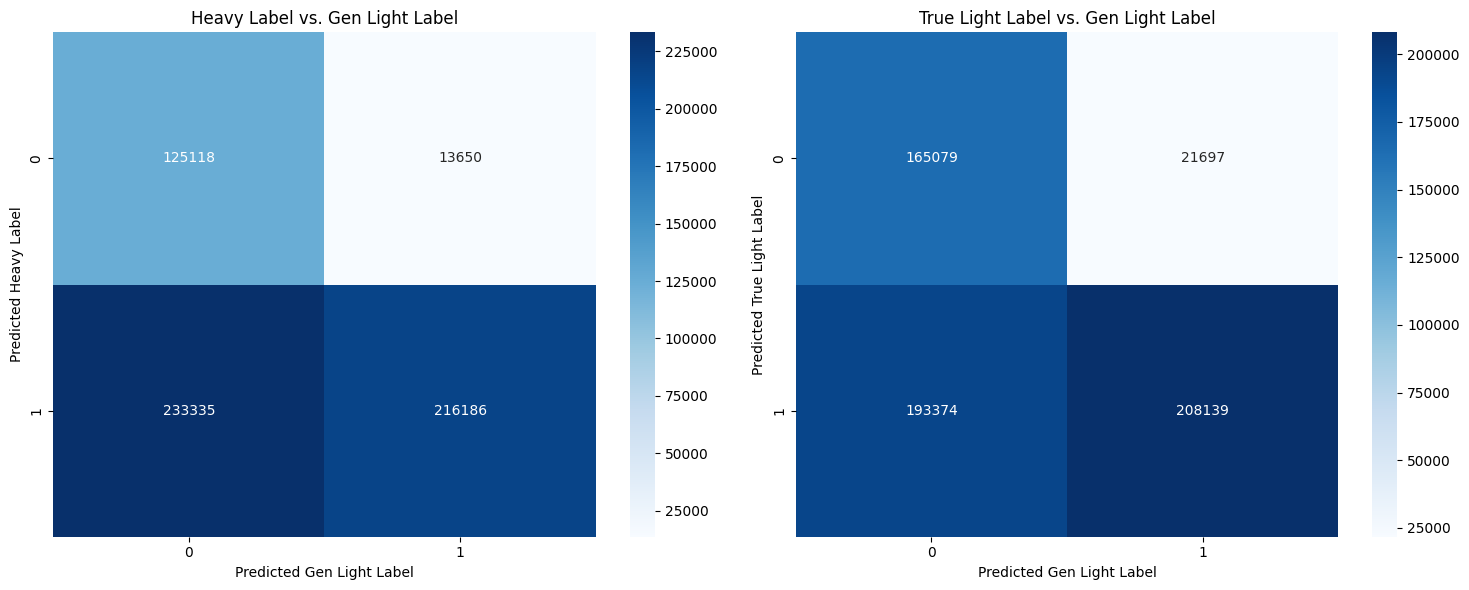

Classification Report - Heavy vs Gen Light:
              precision    recall  f1-score   support

           0       0.35      0.90      0.50    138768
           1       0.94      0.48      0.64    449521

    accuracy                           0.58    588289
   macro avg       0.64      0.69      0.57    588289
weighted avg       0.80      0.58      0.61    588289


Classification Report - True Light vs Gen Light:
              precision    recall  f1-score   support

           0       0.46      0.88      0.61    186776
           1       0.91      0.52      0.66    401513

    accuracy                           0.63    588289
   macro avg       0.68      0.70      0.63    588289
weighted avg       0.76      0.63      0.64    588289


Confusion Matrix 1 (Heavy vs Gen Light):
[[125118  13650]
 [233335 216186]]

Confusion Matrix 2 (True Light vs Gen Light):
[[165079  21697]
 [193374 208139]]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

df = pd.read_csv('/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2GPT/multiple_light_seqs_from_single_heavy/full_test_set_multiple_light_seqs/full_eval_generate_multiple_light_seqs_203276_cls_predictions.csv')

def create_confusion_matrices(df):
    # Confusion Matrix 1: Predicted Heavy Label vs. Predicted Gen Light Label
    cm1 = confusion_matrix(df['predicted_input_heavy_seq_label'], 
                          df['predicted_gen_light_seq_label'])
    
    # Confusion Matrix 2: Predicted True Light Label vs. Predicted Gen Light Label
    cm2 = confusion_matrix(df['predicted_true_light_seq_label'], 
                          df['predicted_gen_light_seq_label'])
    
    # Get unique labels for each comparison
    heavy_labels = sorted(df['predicted_input_heavy_seq_label'].unique())
    gen_light_labels = sorted(df['predicted_gen_light_seq_label'].unique())
    true_light_labels = sorted(df['predicted_true_light_seq_label'].unique())
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot first confusion matrix
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
                xticklabels=gen_light_labels, yticklabels=heavy_labels,
                ax=axes[0])
    axes[0].set_title('Heavy Label vs. Gen Light Label')
    axes[0].set_xlabel('Predicted Gen Light Label')
    axes[0].set_ylabel('Predicted Heavy Label')
    
    # Plot second confusion matrix
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
                xticklabels=gen_light_labels, yticklabels=true_light_labels,
                ax=axes[1])
    axes[1].set_title('True Light Label vs. Gen Light Label')
    axes[1].set_xlabel('Predicted Gen Light Label')
    axes[1].set_ylabel('Predicted True Light Label')
    
    plt.tight_layout()
    plt.show()
    
    return cm1, cm2

# Call the function
cm1, cm2 = create_confusion_matrices(df)

# Optional: Print classification reports for additional metrics
print("Classification Report - Heavy vs Gen Light:")
print(classification_report(df['predicted_input_heavy_seq_label'], 
                           df['predicted_gen_light_seq_label']))

print("\nClassification Report - True Light vs Gen Light:")
print(classification_report(df['predicted_true_light_seq_label'], 
                           df['predicted_gen_light_seq_label']))

# Optional: Save confusion matrices as arrays for further analysis
print("\nConfusion Matrix 1 (Heavy vs Gen Light):")
print(cm1)
print("\nConfusion Matrix 2 (True Light vs Gen Light):")
print(cm2)